<a href="https://colab.research.google.com/github/trogers19/batting-order-EA/blob/main/BattingOrderEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Batting Order Optimization with Evolutionary Algorithm
Created by Taylor Rogers for Biologically Inspired Computation at UTK in Spring 2022

In [7]:
# Install LEAP, PyBaseball to Google Colab
!pip install leap_ec
!pip install pybaseball

# Uncomment lines 7 and 8 if using Google Drive
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
from toolz import pipe, curry
import argparse
import sys
import random

# Use pybaseball for retrieving baseball-related info
import pybaseball
from pybaseball.league_batting_stats import batting_stats_bref
from pybaseball import batting_stats, player_search_list
from pybaseball import statcast, statcast_batter, get_splits, cache, team_batting

# Enable pybaseball's cache
cache.enable()

# Utilize LEAP for EA
from leap_ec import Individual, context, test_env_var
from leap_ec import ops, probe, util
from leap_ec.decoder import IdentityDecoder
from leap_ec.algorithm import generational_ea
from leap_ec.executable_rep import problems, rules, executable
from leap_ec.int_rep.ops import individual_mutate_randint
from leap_ec.real_rep.ops import genome_mutate_gaussian
from leap_ec.real_rep import create_real_vector
from leap_ec.binary_rep.problems import ScalarProblem
# For mutatation definitions
from typing import Iterator
from leap_ec.ops import compute_expected_probability, iteriter_op

# This function processes roster_file, which should be the file path of the .ROS file
def process_roster(roster_file):

    # Read roster from file and set column names
    roster = pd.read_csv(roster_file, header=None)
    roster.columns = ['Retrosheet ID', 'Last Name', 'First Name', 'Bats', 'Throws', 'Team', 'Position']
    
    # Add IDs for Statcast and Baseball Reference
    names = [(roster['Last Name'][i], roster['First Name'][i]) for i in roster.index]
    player_info = player_search_list(names)
    roster['Statcast ID'] = player_info['key_mlbam']
    roster['Baseball Reference ID'] = player_info['key_bbref']
    roster['Fangraphs ID'] = player_info['key_fangraphs']

    # Create dictionary for Retrosheet IDs to names
    retrosheet_id_to_name = {}
    for i in roster.index:
        retrosheet_id_to_name[roster['Retrosheet ID'][i]] = roster['First Name'][i] + ' ' + roster['Last Name'][i]
    
    # Manually fixing this for now
    retrosheet_id_to_name['voged001'] = 'Daniel Vogelbach'

    return roster, retrosheet_id_to_name

# Implementation of batting order problem
class battingOrderProblem(ScalarProblem):
    def __init__(self):
        super().__init__(maximize=True)
        self.data = pybaseball.batting_stats(2021, qual=0)
        self.team_data = self.data

    # Fitness function to maximize - the main focus of this project
    def evaluate(self, ind):

        """
        To Do:
            Add something to account for ... 
                Relative orrder of players in the lineup
                RHH and LHH
                ...
        """

        # Positions needed to be filled in lineup 
        positions_needed = ['DH', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
        
        # For simplicity without simulation, evaluate based on combined stats 

        # Get list of names from the current lineup
        lineup_names = []

        for player_id in ind:
            lineup_names.append(retrosheet_id_to_name[player_id])

        lineup_data = self.team_data[self.team_data.Name.isin(lineup_names)]

        # This may not be a great solution - work on something better when time allows
        if lineup_data.shape[0] < 9:
            num_not_hitting = 9 - lineup_data.shape[0]
            blank_rows = pd.DataFrame(data=0, index=np.arange(num_not_hitting), columns=lineup_data.columns)
            lineup_data = pd.concat([lineup_data, blank_rows])

        # Work on getting all positions in the lineup
        position_penalty = 0
        for i in lineup_data.index:
            fangraph_id = lineup_data.loc[i, 'IDfg']
            player = roster[roster['Fangraphs ID'] == fangraph_id]
            if player.size == 0: continue
            position_covered = player.iloc[0]['Position']
            if position_covered in positions_needed:
                positions_needed.remove(position_covered)
            elif 'DH' in positions_needed:
                positions_needed.remove('DH')
            else:
                position_penalty += 5

        lineup_stats_only = lineup_data.copy()
        lineup_stats_only = lineup_stats_only.drop(columns=['IDfg', 'Season', 'Name', 'Team'])
        lineup_stats_only = lineup_stats_only.fillna(0)


        # Account for players with limited PAs - this threshold may need to be changed
        for i in lineup_stats_only.index:
            if (lineup_stats_only.loc[i, 'PA'] < 150):
                lineup_stats_only.loc[i, 'xwOBA'] = 0

        # Get average stats for this lineup
        avgs = lineup_stats_only.mean()
        avgBA = avgs['AVG']
        avgOPS = avgs['OPS']

        # For practical use, this will need to be much more intentional
        # This is currently more of a proof of concept to see what happens
        fit = avgs['xwOBA'] * 10 + lineup_stats_only.iloc[0]['BsR'] / 5

        # Leadoff hitter should have a high OBS, bonus if he is a good base runner
        leadoff_fitness = lineup_stats_only.iloc[0]['OBP'] * 2 + lineup_stats_only.iloc[0]['BsR']

        fit = avgs['xwOBA'] * 100 + leadoff_fitness - position_penalty

        return fit

def create_lineup(roster):
    # Create lineup from roster, which should be passed in as a Pandas DataFrame
    # Players will be represented by their Retrosheet ID
    # This currently has no restrictions - those will be imposed or developed through the fitness function
    def create():
        lineup = roster.sample(n=9)['Retrosheet ID']
        return np.asarray(lineup)
    return create

# Specifying custom mutation functions to work with LEAP
@curry
@iteriter_op
def mutate_lineup(next_individual: Iterator,
                   expected_num_mutations: float = None,
                   roster: pd.DataFrame = None) -> Iterator:

    # Perform mutation on each individual (lineup) in an iterator (population)
    while True:
        individual = next(next_individual)
        individual.genome = genome_mutate_lineup(individual.genome,
                                                      expected_num_mutations=expected_num_mutations,
                                                      roster=roster)
        individual.fitness = None  # Invalidate fitness since we have new genome
        yield individual

# Specifying custom mutation functions to work with LEAP
@curry
def genome_mutate_lineup(genome: np.ndarray,
                          expected_num_mutations: float = None,
                          roster: pd.DataFrame = None) -> np.ndarray:

    # Perform mutation on a particular genome (lineup)
    # Mutate the current lineup by randomly replacing a player
    mutated_lineup = genome
    
    # Pick a random player that is not in the current lineup
    while True:
      player = list(roster.sample()['Retrosheet ID'])[0]
      if player not in genome: break

    # Replace random player with sampled player 
    i = random.randint(0,8)
    mutated_lineup[i] = player

    return mutated_lineup

if __name__ == '__main__':

    """
    # Commented out for use in Google Colab
    # If running full py file, can uncomment this, comment out the manual input of variables below, and specify these on the command line
    parser = argparse.ArgumentParser(description="Evolutionary Algorithm Optimization for Batting Order")
    parser.add_argument("--n", default=50, help="population size", type=int)
    parser.add_argument("--p_m", default=0.01, help="probability of mutation", type=float)
    parser.add_argument("--p_c", default=0.3, help="probability of crossover", type=float)
    parser.add_argument("--trn_size", default=2, help="tournament size", type=int)
    parser.add_argument("--csv_output", required=True, help="csv output file name", type=str)
    args = parser.parse_args()    
    
    N = args.n
    p_m = args.p_m
    p_c = args.p_c
    trn_size = args.trn_size
    """

    # Manually input these for use in Google Colab
    N = 50
    p_m = 0.05
    p_c = 0.05
    trn_size = 5

    # Read roster from file and set column names
    # Make sure this is set to the intended file path
    # roster_file = 'MIL2021.ROS'
    roster_file = 'https://raw.githubusercontent.com/trogers19/batting-order-EA/main/MIL2021.ROS'
    roster, retrosheet_id_to_name = process_roster(roster_file)

    # Max gen and genome length
    max_generation = 30

    total_runs = 20

    for run_num in range(total_runs):

        # Set up file path to print results to csv so progress can be observed more closely
        output_fn = 'test' + str(run_num) + '.csv'

        # Create initial population
        parents = Individual.create_population(N, initialize=create_lineup(roster), decoder=IdentityDecoder(), problem=battingOrderProblem())

        # Evaluate initial population
        parents = Individual.evaluate_population(parents)

        # Use LEAP to handle evolution
        generation_counter = util.inc_generation()
        out_f = open(output_fn, "w")
        while generation_counter.generation() < max_generation:
            offspring = pipe(parents,
                            ops.tournament_selection(k=trn_size),
                            ops.clone,
                            mutate_lineup(roster=roster),
                            ops.uniform_crossover(p_xover=p_c),
                            ops.evaluate,
                            ops.pool(size=len(parents)),  # Accumulate offspring
                            probe.AttributesCSVProbe(stream=out_f, do_fitness=True, do_genome=True) # Print step, fitness, and genome to CSV at each step
                            )
            
            parents = offspring
            generation_counter()  # Increment to the next generation

        # Update user to show progress
        print(f'Run {run_num} of {total_runs} complete')

        out_f.close()
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Run 0 of 20 complete
Run 1 of 20 complete
Run 2 of 20 complete
Run 3 of 20 complete
Run 4 of 20 complete
Run 5 of 20 complete
Run 6 of 20 complete
Run 7 of 20 complete
Run 8 of 20 complete
Run 9 of 20 complete
Run 10 of 20 complete
Run 11 of 20 complete
Run 12 of 20 complete
Run 13 of 20 complete
Run 14 of 20 complete
Run 15 of 20 complete
Run 16 of 20 complete
Run 17 of 20 complete
Run 18 of 20 complete
Run 19 of 20 complete


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Run 0 of 20 complete
Run 1 of 20 complete
Run 2 of 20 complete
Run 3 of 20 complete
Run 4 of 20 complete



    Thoughts through development: 
    Requirements for batting order: 
        9 players, one for each defensive position plus a DH

    Things to consider in choosing an order:
        Some balance of RHHs and LHHs
            Likely depends on opposing pitcher
        Relative order should be productive in some way
            Generate runs
        Traditional and more SABR-oriented approaches
            Leaedoff hitter should be relatively fast
            Cleanup hitter should be relatively powerful
            Breakup patterns of RHH/LHH and slow players to prevent DPs

The cell below is used just to test pieces of the code above.

In [3]:
import numpy as np
import pandas as pd
from pybaseball.league_batting_stats import batting_stats_bref
from pybaseball import batting_stats, player_search_list
from pybaseball import statcast, statcast_batter, get_splits, cache, team_batting

cache.enable()

# Fitness function to maximize - the main focus of this project
"""
To Do:
    Add something to account for ... 
        Order of players in the lineup
        RHH and LHH
        Speed of leadoff hitter (try to use SB)
        Players who don't qualify to hit (choose a threshold of ABs maybe?)
            Give a 0 for people who do not qualify to discourage that (the player is basically worthless to the fitness of the lineup)
        
"""
# Fitness function to maximize - the main focus of this project
def evaluate_lineup(lineup):

    data = pybaseball.batting_stats(2021, qual=0)
    team_data = data[data.Team.str.contains('MIL', na=False)]
    team_data = data
    # Positions needed to be filled in lineup 
    # These aren't yet being used, but I hope to add something with them
    positions_needed = ['DH', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
    
    # For simplicity without simulation, evaluate based on combined stats 

    # Get list of names from the current lineup
    lineup_names = []
    true_lineup_names = ['Kolten Wong', 'Lorenzo Cain', 'Christian Yelich', 'Travis Shaw', 'Avisail Garcia', 'Daniel Vogelbach', 'Luis Urias', 'Luke Maile', 'Adrian Houser']

    for player_id in lineup:
        lineup_names.append(retrosheet_id_to_name[player_id])
      
    print(lineup_names)

    # Clean way to do it
    lineup_data = team_data[team_data['Name'].isin(lineup_names)]

    true_lineup_data = team_data[team_data['Name'].isin(true_lineup_names)]

    # Work on getting all positions in the lineup
    position_penalty = 0
    for i in lineup_data.index:
        fangraph_id = lineup_data.loc[i, 'IDfg']
        player = roster[roster['Fangraphs ID'] == fangraph_id]
        position_covered = player.iloc[0]['Position']
        print(position_covered)
        if position_covered in positions_needed:
            positions_needed.remove(position_covered)
        elif 'DH' in positions_needed:
            positions_needed.remove('DH')
        else:
            position_penalty += 5
    

    # This is NOT a good solution - come up with something better when time allows
    if lineup_data.shape[0] < 9:
        num_not_hitting = 9 - lineup_data.shape[0]
        blank_rows = pd.DataFrame(data=0, index=np.arange(num_not_hitting), columns=lineup_data.columns)
        lineup_data = pd.concat([lineup_data, blank_rows])

    if true_lineup_data.shape[0] < 9:
        num_not_hitting = 9 - lineup_data.shape[0]
        blank_rows = pd.DataFrame(data=0, index=np.arange(num_not_hitting), columns=true_lineup_data.columns)
        true_lineup_data = pd.concat([true_lineup_data, blank_rows])

    print('Evolved lineup')
    print(lineup_data)
    print('Real lineup')
    print(true_lineup_data)

    lineup_stats_only = lineup_data.copy()
    lineup_stats_only = lineup_stats_only.drop(columns=['IDfg', 'Season', 'Name', 'Team'])
    lineup_stats_only = lineup_stats_only.fillna(0)

    true_lineup_stats_only = true_lineup_data.copy()
    true_lineup_stats_only = true_lineup_stats_only.drop(columns=['IDfg', 'Season', 'Name', 'Team'])
    true_lineup_stats_only = true_lineup_stats_only.fillna(0)

    penalty = 0

    # Account for players with limited PAs - this threshold may need to be changed
    for i in lineup_stats_only.index:
        if (lineup_stats_only.loc[i, 'PA'] < 150):
            lineup_stats_only.loc[i, 'AVG'] = 0
            lineup_stats_only.loc[i, 'OPS'] = 0
            lineup_stats_only.loc[i, 'xwOBA'] = 0
            penalty += 1

    for i in true_lineup_stats_only.index:
        if (true_lineup_stats_only.loc[i, 'PA'] < 150):
            true_lineup_stats_only.loc[i, 'AVG'] = 0
            true_lineup_stats_only.loc[i, 'OPS'] = 0
            true_lineup_stats_only.loc[i, 'xwOBA'] = 0
            penalty += 1

    # Leadoff hitter should have a high OBS, bonus if he is a good base runner
    leadoff_fitness = lineup_stats_only.iloc[0]['OBP'] * 2 + lineup_stats_only.iloc[0]['BsR']
    # print(f'Leadoff fitness is {leadoff_fitness}')

    # Get average stats for this lineup
    avgs = lineup_stats_only.mean()
    avgBA = avgs['AVG']
    avgOPS = avgs['OPS']

    print(f"Evolved avg xwOBA is {avgs['xwOBA']}")
    print(f"Evolved leadoff BsR is {lineup_stats_only.iloc[0]['BsR']}")
    print(f"Evolved leadoff OBP is {lineup_stats_only.iloc[0]['OBP']}")

    true_avgs = true_lineup_stats_only.mean()
    true_leadoff_fitness = true_lineup_stats_only.iloc[0]['OBP'] * 2 + true_lineup_stats_only.iloc[0]['BsR']
    true_fit1 = true_avgs['xwOBA'] 
    true_fit2 = true_avgs['xwOBA'] * 100 + true_leadoff_fitness
    # print(f'True fitnesses are {true_fit1} and {true_fit2}')
    print(f"True avg xwOBA is {true_avgs['xwOBA']}")
    print(f"True leadoff BsR is {true_lineup_stats_only.iloc[0]['BsR']}")
    print(f"True leadoff OBP is {true_lineup_stats_only.iloc[0]['OBP']}")

    # fit1 and fit2 can be calculated differently to see how relevant certain stats may be for a particular batting order
    fit1 = avgs['xwOBA'] 
    fit2 = avgs['xwOBA'] * 100 + leadoff_fitness - position_penalty

    return fit1, fit2

if __name__ == '__main__':

    # winning_lineup should be a relatively fit individual produced through evolution (what the algorithm determines to be "good")
    winning_lineup = ['tellr001', 'garca003', 'pinam001', 'escoe001', 'yelic001', 'cainl001', 'adamw002', 'petej002', 'voged001']

    # true_lineup_names describes the starting batting order used by the Brewers on August 17, 2021
    # This is utilized similar to a ground truth for comparison
    true_lineup_names = ['Kolten Wong', 'Willy Adames', 'Christian Yelich', 'Eduardo Escobar', 'Omar Narvaez', 'Avisail Garcia', 'Rowdy Tellez', 'Lorenzo Cain', 'Corbin Burnes']

    # Evaluate the fitness of the winning lineup
    fit1, fit2 = evaluate_lineup(winning_lineup)

    # Print information to gauge the algorithm's output
    print("Fitness 1 is {}, fitness 2 is {}".format(fit1, fit2))
    print("Positions covered by lineup: {}".format(roster['Position'].unique()))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Rowdy Tellez', 'Avisail Garcia', 'Manny Pina', 'Eduardo Escobar', 'Christian Yelich', 'Lorenzo Cain', 'Willy Adames', 'Jace Peterson', 'Daniel Vogelbach']
SS
OF
3B
OF
C
OF
2B
1B
1B
Evolved lineup
      IDfg  Season              Name   Team  Age    G   AB   PA    H  1B  ...  \
133  15986    2021      Willy Adames  - - -   25  140  497  555  130  72  ...   
151   5760    2021    Avisail Garcia    MIL   30  135  461  515  121  74  ...   
192   6153    2021   Eduardo Escobar  - - -   32  146  549  599  139  80  ...   
242  11477    2021  Christian Yelich    MIL   29  117  399  475   99  69  ...   
292   2829    2021        Manny Pina    MIL   34   75  180  208   34  15  ...   
271   9077    2021      Lorenzo Cain    MIL   35   78  257  286   66  45  ...   
272  12325    2021     Jace Peterson    MIL   31   94  259  302   64  46  ...   
245  14130    2021  Danie

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [4]:
# Print the roster - may be useful for comparing players
print(roster)

   Retrosheet ID   Last Name First Name Bats Throws Team Position  \
0       adamw002      Adames      Willy    R      R  MIL       SS   
1       andeb004    Anderson      Brett    L      L  MIL        P   
2       arcio002       Arcia    Orlando    R      R  MIL       SS   
3       ashba003       Ashby      Aaron    R      L  MIL        P   
4       axfoj001      Axford       John    R      R  MIL        P   
..           ...         ...        ...  ...    ...  ...      ...   
57      woodb005    Woodruff    Brandon    L      R  MIL        P   
58      yarde001     Yardley       Eric    R      R  MIL        P   
59      yelic001      Yelich  Christian    L      R  MIL       OF   
60      zimmj003  Zimmermann     Jordan    R      R  MIL        P   
61      escoe001     Escobar    Eduardo    S      R   2B      NaN   

    Statcast ID Baseball Reference ID  Fangraphs ID  
0        642715             adamewi01         15986  
1        474463             anderbr04          8223  
2        

Code to consolidate calculations by generation and graph

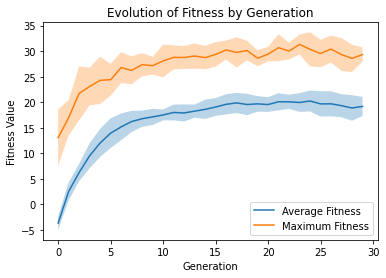

In [5]:

# Imports
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from matplotlib import cm
import seaborn as sns

def get_std(ls):
	num = len(ls)
	mean = sum(ls) / num
	var = sum((x - mean)**2 for x in ls) / num
	std_dev = var ** 0.5
	return std_dev

headers = ['iteration', 'generation', 'average_fit', 'best_fitness', 'best_genome']

run_numbers = []
for r in range(total_runs):
    run_numbers.append(r)

# Open csv file
fout = open('final_project_calc.csv', mode = 'w', newline = '')
fwrite = csv.writer(fout)
fwrite.writerow(headers)

# Data array
data = []
avg_fitnesses = []
max_fitnesses = []

for run in run_numbers:

    # Loop and open all files
    # Open and read CSV data
    fin_name = 'test' + str(run) + '.csv'
    fin = open(fin_name, mode = 'r')
    csvFile = csv.reader(fin)

    # Declare variables
    n = 0
    gen = -1
    total = 0
    avg_fit = 0
    best_fit = 0
    best_gen = []

    # Read through csv
    for line in csvFile:
      # Check input
      if line[0] == 'step':
        # Average fit
        if n != 0:
          avg_fit = total / n

        # Add data to array
        if gen > -1 and gen != 29:
          data.append([run, gen, avg_fit, best_fit, best_gen])
          avg_fitnesses.append(avg_fit)
          max_fitnesses.append(best_fit)

        # Declare variables
        n = 0
        total = 0
        avg_fit = 0
        best_fit = 0
        best_gen = []
      else:
        # Initialize variables
        step = line[0]
        gen = int(step)
        tmp = line[1]
        genome = line[2]
        fitness = 0
        n += 1

        # Handle scientific notation
        if 'e' in tmp:
          tmp_array = tmp.split('e')
          tmp_array2 = tmp_array[1].split('-')
          num = float(tmp_array[0])
          exp = int(tmp_array2[1])
          exp *= -1
          fitness = num * (10 ** exp)
        else:
          fitness = float(tmp)

        # Check for best fitness
        if fitness > best_fit:
          best_fit = fitness
          best_gen = genome

        # Add fitness to total
        total += fitness

    # Append last generation
    avg_fit = total / n
    data.append([run, gen, avg_fit, best_fit, best_gen])
    avg_fitnesses.append(avg_fit)
    max_fitnesses.append(best_fit)

    # Write and close files
    fin.close()
    
fwrite.writerows(data)
fout.close()

"""
Now graph averages from the 20 runs
There should be a line corresponding to each run for each generation (20 runs, 50 generations)
Want the average avg_fitness and max_fitness of the runs at each generation
"""

# Open the full csv to use for graphing
fin = open('final_project_calc.csv', mode = 'r')
csvFin = csv.reader(fin)

avg = {}
best = {}

for line in csvFin:
    if line[0] == 'iteration': continue

    gen = int(line[1])

    if gen not in avg:
        avg[gen] = []
        best[gen] = []
    avg[gen].append(float(line[2]))
    best[gen].append(float(line[3]))

fin.close()

# Calculate average and std dev areas for generation over the runs
means = []
top25 = []
bot25 = []

# For each run, calculate the mean and mean +- 1 std dev of the average fitness values
for i in avg:
	mean = sum(avg[i]) / len(avg[i])
	means.append(mean)
	top25.append(mean + get_std(avg[i]))
	bot25.append(mean - get_std(avg[i]))

# Plot the average fitness line, shade region within 1 standard deviation
plt.plot(range(gen+1), means, label='Average Fitness')
plt.fill_between(range(gen+1), top25, bot25, alpha=0.3)

# Do the same for maximum fitness values
means = []
top25 = []
bot25 = []

# For each run, calculate the mean and mean +- 1 std dev of the max fitness values
for i in avg:
	mean = sum(best[i]) / len(best[i])
	means.append(mean)
	top25.append(mean + get_std(best[i]))
	bot25.append(mean - get_std(best[i]))

# Plot the average max fitness, shade region within 1 standard deviation
plt.plot(range(gen+1), means, label='Maximum Fitness')
plt.fill_between(range(gen+1), top25, bot25, alpha=0.3)

# Set the title, axis labels, and legend
plt.title('Evolution of Fitness by Generation')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.legend(loc='lower right')

# Save and show the figure (can change file name if desired)
plt.savefig('EvolutionGraph.png')
plt.show()


In [6]:
# Print max fitness and average max fitness
print("Max fitness: {}".format(max(max_fitnesses)))
print("Genome with highest fitness: {}".format(np.argmax(max_fitnesses)))

Max fitness: 33.951777777777785
Genome with highest fitness: 54
